## Python script to visualize ancestor and extant nodes in 2D Space

In [1]:
import mca
import pandas as pd
import prince
from pysam import FastaFile,FastxFile
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np
from ete3 import Tree
import json
from collections import defaultdict

In [2]:
def process_node_type(json_file):
    ''' mark nodes as extants or ancestor '''
    node_type_dict = defaultdict(list)
    # read the json file
    with open(json_file, 'r') as j:
        pog_all_data = json.loads(j.read())

        # read all ancestors
        for node_type in ['Ancestors','Extants']:
            for pog_data in pog_all_data[node_type]:
                if node_type == 'Ancestors':
                    node_name = 'N' + pog_data['Name']
                    node_type_dict['Ancestor'] += [node_name]
                else:
                    node_name = pog_data['Name']
                    node_type_dict['Extant'] += [node_name]

    return node_type_dict

''' process fasta file and convert sequences into 1/0 '''
def process_sequences(ancestor_fasta_file):
    all_seq_list = {}
    sequences_info = FastaFile(ancestor_fasta_file)
    with FastxFile(ancestor_fasta_file) as fh:
        for entry in fh:
            # convert into 1/0
            grasp_output_seq =  re.sub('[a-zA-Z]', '1', str(entry.sequence) )
            grasp_output_seq = grasp_output_seq.replace('-','0')
            all_seq_list[entry.name] = [g for g in grasp_output_seq]
    data = pd.DataFrame(all_seq_list)
    data = data.T
    return data

''' run mca on the data '''
def run_mca(data,node_type_dict):
    mca = prince.MCA(n_components=2,
    n_iter=100,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42)
    mca.fit(data)
    mca = mca.transform(data) # same as calling ca.fs_r_sup(df_new) for *another* test set.
    mca_df = pd.DataFrame(mca)
    mca_df = mca_df.rename(columns={0: 'pc_1', 1: 'pc_2'})
    mca_df['node_name'] = mca_df.index
    mca_df['node_type'] = mca_df['node_name'].apply(lambda x: 'Ancestor' if \
                                                x in node_type_dict['Ancestor'] else 'Extant')
    return mca_df

''' create co-ordinates for arrows '''
def create_pts_arrow_coordinates(nwk_file_path,mca_df):
    tree_file = open(nwk_file_path,"r")
    my_tree = tree_file.read() + ";"
    tree = Tree(my_tree, format=1)
    arrow_cord = []
    name_pnts = []
    
    for n in tree.traverse():
        node  = n.name
        x = mca_df[mca_df['node_name'] == node]['pc_1'].values[0]
        y = mca_df[mca_df['node_name'] == node]['pc_2'].values[0]
        name_pnts.append((x+0.02,y,node))
        
        if n.is_leaf() == False:    
            for c in n.children:
                child = c.name
                # get co-ordinates
                dx = mca_df[mca_df['node_name'] == child]['pc_1'].values[0] - \
                            mca_df[mca_df['node_name'] == node]['pc_1'].values[0]
                dy = mca_df[mca_df['node_name'] == child]['pc_2'].values[0] - \
                            mca_df[mca_df['node_name'] == node]['pc_2'].values[0]
                arrow_cord.append((x,y,dx,dy,node))               
    return arrow_cord,name_pnts


''' plot the data in 2d space'''
def plot_fig(mca_df,show_nodes,show_arrow,show_names):
    if show_nodes == 'All':
        sns.lmplot(x='pc_1', y='pc_2', data=mca_df, hue='node_type', \
                    fit_reg=False) #, x_jitter=0.2, y_jitter=0.2)
    else:
        mca_df_filtered = mca_df[mca_df['node_type'] == show_nodes]
        sns.lmplot(x='pc_1', y='pc_2', data=mca_df_filtered, \
                   fit_reg=False)

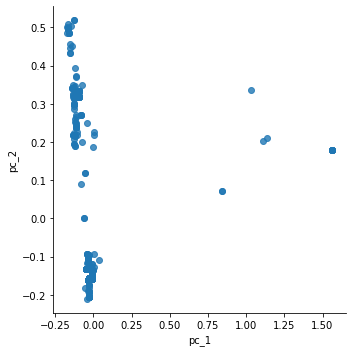

In [17]:
# GRASP OUTPUT

nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/grasp_ancestors.nwk'
ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/grasp_ancestors.fa"
pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/pogs.json'
node_type_dict = process_node_type(pogs_file)
data = process_sequences(ancestor_fasta_file)
mca_df = run_mca(data,node_type_dict)
#arrow_cord,name_pnts = create_pts_arrow_coordinates(nwk_file_path,mca_df)
plot_fig(mca_df,show_nodes='Ancestor',show_arrow=0,show_names=1) # Ancestor #All #Extant

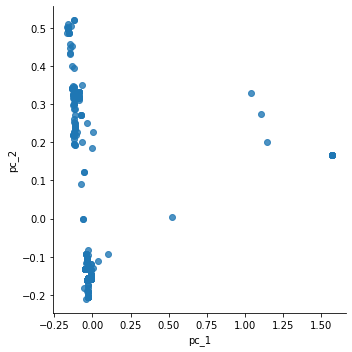

In [16]:
# MIP OUTPUT - MIP 1

nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/grasp_ancestors.nwk'
ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/mip_grasp_ancestors.fa"
pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/pogs.json'
node_type_dict = process_node_type(pogs_file)
data = process_sequences(ancestor_fasta_file)
mca_df = run_mca(data,node_type_dict)
#arrow_cord,name_pnts = create_pts_arrow_coordinates(nwk_file_path,mca_df)
plot_fig(mca_df,show_nodes='Ancestor',show_arrow=0,show_names=1) # Ancestor #All #Extant

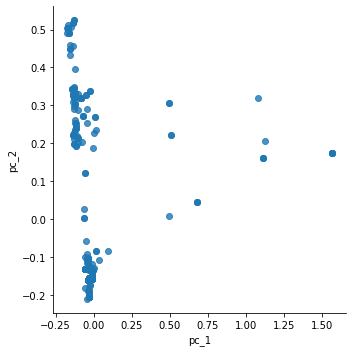

In [18]:
# MIP OUTPUT - EXTANTS EDGES ONLY (MIP 2)

nwk_file_path       = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/grasp_ancestors.nwk'
ancestor_fasta_file = "/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/mip_grasp_ancestors_extant_edges.fa"
pogs_file           = '/Users/sanjanatule/Documents/uq/Projects/PreferredPath/data/CYP2U_595/pogs.json'
node_type_dict = process_node_type(pogs_file)
data = process_sequences(ancestor_fasta_file)
mca_df = run_mca(data,node_type_dict)
#arrow_cord,name_pnts = create_pts_arrow_coordinates(nwk_file_path,mca_df)
plot_fig(mca_df,show_nodes='Ancestor',show_arrow=0,show_names=1) # Ancestor #All #Extant

## EXTRA CODE

In [6]:
#plot_fig(mca_df,arrow_cord,name_pnts,show_nodes='Extant',show_arrow=0,show_names=1) # Ancestor #All #Extant

In [7]:
#plot_fig(mca_df,arrow_cord,name_pnts,show_nodes='Ancestor',show_arrow=0,show_names=1) # Ancestor #All #Extant

In [8]:
# ''' plot the data in 2d space'''
# def plot_fig(mca_df,arrow_cord,name_pnts,show_nodes,show_arrow,show_names):
    
    #fig = plt.figure(figsize=(20, 10))
    #ax  = fig.add_subplot(2, 1, 2)
#     color = {'Ancestor':'blue','Extant':'orange'}
    
#     plt.xlim(mca_df['pc_1'].min(), mca_df['pc_1'].max())
#     plt.ylim(mca_df['pc_2'].min(), mca_df['pc_2'].max())

#     if show_nodes == 'All':
#         sns.lmplot(x='pc_1', y='pc_2', data=mca_df, hue='node_type', fit_reg=False, x_jitter=0.1, y_jitter=0.1)
        
#         groups = mca_df.groupby('node_type')
#         for name, group in groups:
#             plt.plot(group.pc_1, group.pc_2, marker='o', linestyle='', markersize=5, label=name,c=color[name])
            
        # plot arrows
#         if show_arrow == 1:
#             for a in arrow_cord:
#                 ax.arrow(a[0], a[1], a[2], a[3],width=0.000001,color='grey',\
#                       length_includes_head=True,head_width=0.009)
            
        # plot text
#         if show_names == 1:
#             for n in name_pnts:
#                 ax.text(n[0], n[1], n[2], fontsize=12) 
#         plt.legend()
        
#     else:
#         mca_df_filtered = mca_df[mca_df['node_type'] == show_nodes]
#         sns.lmplot(x='pc_1', y='pc_2', data=mca_df_filtered, palette=color[show_nodes], \
#                    fit_reg=False, x_jitter=0.1, y_jitter=0.1)
        
#         mca_df_filtered = mca_df[mca_df['node_type'] == show_nodes]
#         plt.plot(mca_df_filtered.pc_1, mca_df_filtered.pc_2, marker='o', linestyle='', markersize=5,\
#                      c=color[show_nodes])
        
#         # plot arrows
#         if show_arrow == 1:
#             for a in arrow_cord:

#                 if a[4] in node_type_dict[show]:
#                     ax.arrow(a[0], a[1], a[2], a[3],width=0.000001,color='grey',\
#                           length_includes_head=True,head_width=0.009)
        
#         # plot text
#         if show_names == 1:
#             for n in name_pnts:
#                 if n[2] in node_type_dict[show]:
#                     ax.text(n[0], n[1], n[2], fontsize=12) 
#         plt.legend([show_nodes])